# Projekt - Eksploracyjna Analiza Danych

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

Na początku skupmy się na salonie, wczytajmy wszystkie dane zebrane z salonu oraz takie które moga mieć wpływ na pomiary tam przeprowadzone.
<h2>Salon</h2>

In [2]:
def prepare_table(csv_name,col_name):
    df = pd.read_csv(csv_name, skiprows=0)                                #czytamy tabele
    df.time = pd.to_datetime(df.time)                                     #zmieniamy kolumne time na datetime
    df.time = df.time.apply(lambda x: x.replace(microsecond=0, second=0)) #zerujemy mikrosekundy i sekundy zeby znalezc odpowiadajace sobie pomiary
    df = df.set_index("time")                                             #ustawiamy czas jako index
    df = df.rename(columns={'value' : col_name})                          #zmieniamy nazwe kolumny
    df = df.drop(columns="name")                                          #usuwamy niepotrzebna kolumne
    df = df[~df.index.duplicated(keep='first')]                           #usuwamy duplikaty indexów     
    return df

In [3]:
temp_salon = prepare_table("Temperatura_Salon.csv","actual_temp")
setpoint_salon = prepare_table("Setpoint_Salon.csv","set_temp")
grzej_salon = prepare_table("Grzejnik_Salon.csv","heater_state")
tryb_salon = prepare_table("Tryb_Salon.csv","mode")
cbo = prepare_table("Centralne_BlokadaOgrzewania.csv","cbo_state")
press = prepare_table("CisnienieAtmosferyczne.csv","pressure")
humidity = prepare_table("WilgotnoWzglendna.csv","humidity")
outside = prepare_table("TemperaturaZewnetrzna.csv","outside_temp")

salon_data = pd.concat([temp_salon,setpoint_salon,outside,grzej_salon,tryb_salon,cbo,press,humidity], axis=1)
salon_data.ffill(inplace=True)        
salon_data.backfill(inplace=True)
salon_data.reset_index(inplace=True)

#przewidziec fakt ze temp wzrasta powyzej set temp

#zaproponowac rozwiazanie

#badanie gradientów temperatur

#jak szybko temperatura rosnie/maleje - jak szybko sie zmienia

Po połączeniu danych mogących przydać się do poprawy ogrzewania w salonie przygotowujemy tabelę do analizy.

Dodajemy następujące kolumny:
* `delta_temp` - Zmiana temperatury względem 6 pomiarów w tył.
* `temp_change_factor` - Delta temperauty z kolumy `delta_temp` podzielona przez czas w minutach od róznicowanego pomiaru.
* `more_than_setpoint` - Czy aktualna temperatura wynosi więcej niż setpoint? (Przy założeniach że ogrzewanie nie jest w trybie nocnym [`cbo_state`!=1] oraz ze nie jest to moment w którym temperatura została dopiero co zmniejszona przez użytkownika.
* `temp_breakdown` - Czy w jednym z następnych 6 pomiarów nastąpi przebicie temperatury? (Przy założeniu że poprzedni pomiar nie był przebiciem stepointu oraz że przebicie jest spowodowane wzrostem temperatury.

Dla sprawdzenia poprawności wyświetlam ostatnie 100 rekordów z naszej tabeli.

In [4]:
first = 0
before = np.NaN


for index, values in salon_data.iterrows():
    if index==first:
        before = index
    if index>5:
        delta_temp = salon_data.actual_temp[index] - salon_data.actual_temp[before]
        delta_time = salon_data.time[index] - salon_data.time[before]
        salon_data.at[index, 'delta_temp'] = delta_temp   #zmiana temperatury wzgledem poprzedniego pomiaru
        salon_data.at[index, "temp_change_factor"] = (delta_temp/(delta_time / dt.timedelta(minutes=1)))
        salon_data.at[index, "more_than_setpoint"] = salon_data.at[index,"actual_temp"]>salon_data.at[index,"set_temp"] and salon_data.at[index,"set_temp"]!=7.0 and salon_data.at[index,"set_temp"]>=salon_data.at[index-1,"set_temp"]
        if (salon_data.at[before+1, "more_than_setpoint"]==True or salon_data.at[before+2, "more_than_setpoint"]==True or salon_data.at[before+3, "more_than_setpoint"]==True or salon_data.at[before+4, "more_than_setpoint"]==True or salon_data.at[before+5, "more_than_setpoint"]==True or salon_data.at[index, "more_than_setpoint"]==True):
            salon_data.at[before, "temp_breakdown"] = salon_data.at[before,"temp_change_factor"]>0 or salon_data.at[before+1,"temp_change_factor"]>0 or salon_data.at[before+2,"temp_change_factor"]>0 or salon_data.at[before+3,"temp_change_factor"]>0 or salon_data.at[before+4,"temp_change_factor"]>0 or salon_data.at[before+5,"temp_change_factor"]>0 or salon_data.at[index,"temp_change_factor"]>0
        before = before+1
        
salon_data.fillna(inplace=True,value=0)
salon_data["more_than_setpoint"] = salon_data["more_than_setpoint"].astype(int)
salon_data["temp_breakdown"] = salon_data["temp_breakdown"].astype(int)


salon_data[['temp_change_factor']] = StandardScaler().fit_transform(salon_data[['temp_change_factor']])
#salon_data[['delta_temp']] = StandardScaler().fit_transform(salon_data[['delta_temp']])

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 1000)

salon_data.head()

,time,actual_temp,set_temp,outside_temp,heater_state,mode,cbo_state,pressure,humidity,delta_temp,temp_change_factor,more_than_setpoint,temp_breakdown
0,2020-09-26 16:10:00,22.2,7.0,13.1,0.0,3.0,1.0,999.0,84.0,0.0,-0.01789,0,0
1,2020-09-26 16:15:00,22.2,7.0,13.1,0.0,3.0,1.0,999.0,84.0,0.0,-0.01789,0,0
2,2020-09-26 16:20:00,22.2,7.0,13.1,0.0,3.0,1.0,999.0,84.0,0.0,-0.01789,0,0
3,2020-09-26 16:25:00,22.2,7.0,13.1,0.0,3.0,1.0,999.0,84.0,0.0,-0.01789,0,0
4,2020-09-26 16:30:00,22.2,7.0,13.1,0.0,3.0,1.0,999.0,84.0,0.0,-0.01789,0,0


Jak można zauważyć na poniższym wykresie kołowym, przez `13%` czasu temperatura osiągała nieporządaną wartość. Natomiast samych przebić temperatury w przeciągu wszystkich dni zarejestrowanych w naszym zbiorze danych było `284`.

0    16069
1     2581
Name: more_than_setpoint, dtype: int64


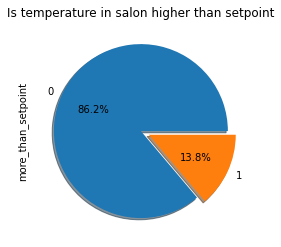

In [6]:
print(salon_data['more_than_setpoint'].value_counts())
salon_data['more_than_setpoint'].value_counts().plot.pie(explode=[0,0.1],shadow=True,autopct='%1.1f%%',
                                              title = 'Is temperature in salon higher than setpoint')

In [7]:
print(salon_data["temp_breakdown"].value_counts())

0    15520
1     3130
Name: temp_breakdown, dtype: int64


Poniżej widzimy dokładny opis danych z kolumny opisującej wzrost temperatury w czasie oraz wszystkie `284` przypadki przebicia temperatury set-pointu spowodowanej wzrostem temperatury.

In [8]:
print(salon_data[salon_data["temp_breakdown"]==1].temp_change_factor.describe())
salon_data[salon_data["temp_breakdown"]==1].head(50)

count    3130.000000
mean        0.506345
std         0.468115
min        -1.123991
25%         0.230983
50%         0.479856
75%         0.789265
max         2.339852
Name: temp_change_factor, dtype: float64


,time,actual_temp,set_temp,outside_temp,heater_state,mode,cbo_state,pressure,humidity,delta_temp,temp_change_factor,more_than_setpoint,temp_breakdown
166,2020-09-27 08:27:00,21.7,22.0,10.0,1.0,1.0,0.0,1002.0,92.0,0.6,1.641262,0,1
167,2020-09-27 08:30:00,21.7,22.0,10.0,1.0,1.0,0.0,1002.0,92.0,0.4,1.553938,0,1
168,2020-09-27 08:33:00,21.9,22.0,10.0,1.0,1.0,0.0,1002.0,92.0,0.6,2.115305,0,1
169,2020-09-27 08:39:00,21.9,22.0,10.0,0.0,1.0,0.0,1002.0,92.0,0.6,1.848656,0,1
170,2020-09-27 08:42:00,21.9,22.0,10.2,0.0,1.0,0.0,1002.0,91.0,0.4,1.176700,0,1
171,2020-09-27 08:45:00,21.9,22.0,10.2,0.0,1.0,0.0,1002.0,91.0,0.2,0.693175,0,1
172,2020-09-27 09:00:00,22.1,22.0,10.2,0.0,1.0,0.0,1002.0,91.0,0.4,0.887102,1,1
173,2020-09-27 09:15:00,22.1,22.0,10.2,0.0,1.0,0.0,1002.0,91.0,0.4,0.645771,1,1
174,2020-09-27 09:28:00,22.1,22.0,10.3,0.0,1.0,0.0,1002.0,91.0,0.2,0.253608,1,1
175,2020-09-27 09:30:00,22.1,22.0,10.3,0.0,1.0,0.0,1002.0,91.0,0.2,0.274902,1,1


Jak widać na poniższej korelacji Pearsona, kolumna `temp_breakdown` wskazująca nam momenty przebicia temperatury ma największe korelacje z kolumnami `more_than_setpoint`, `delta_temp`, `temp_change_factor` czy też `actual_temp`. Do każdego pokoju należy podejść lekko idywiduwalnie dlatego modele dla różnych pokoi mogą przyjmować różne cechy, pewne jest że główną cechą która pojawi się w każdym modelu będzie `temp_change_factor`.

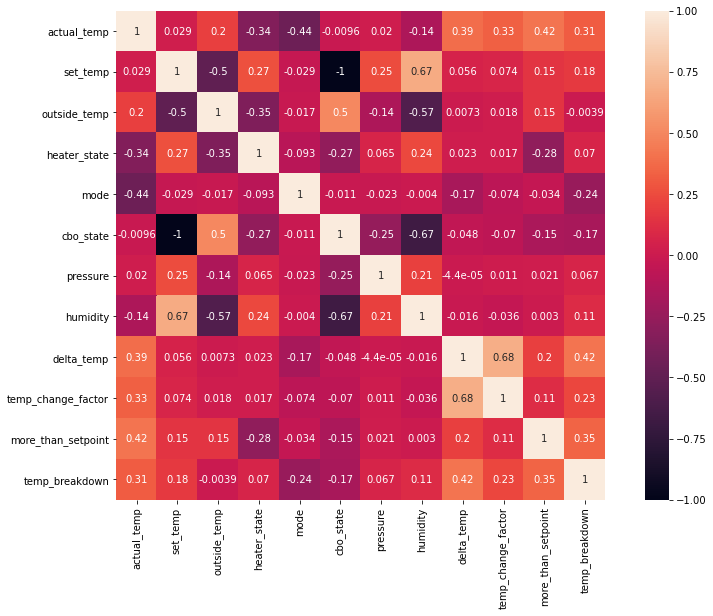

In [9]:
corr = salon_data.corr()
f = plt.figure(figsize = (14,9))
sns.heatmap(corr,vmax = 1,square = True,annot = True,vmin = -1)
plt.show()

Spróbujmy nauczyć model rozpoznawania momentu przebicia set-point'u przez temperaturę, na podstawie tabeli korelacji Pearsona oraz po wielokrotnym testowaniu najlepszych kolumn, wybraliśmy kolumny `cbo_state`, `delta_temp`, oraz `temp_change_factor` jako te które posłużą modelowi jako cechy przy predykcji przebicia. Jak widzimy nasz model ma `79%` dokładności, niestety w tym przypadku dokładność nie jest miarą którą chcemy zmaksymalizować, zależy nam głównie na detekcji przebić a więc skorzystamy z miary F-Beta. Beta określa jak bardzo ważna jest czułość w stosunku do precyzji. Zakładając że zależy nam żeby przewidzieć jak najwięcej anomalii, wartość parametru Beta powinna być wysoka, dla naszego modelu ustaiono ją na `7` i wynosi ona `53%`, co nie jest wcale najgorszym wynikiem biorąc pod uwagę duże niezbalansowanie danych oraz to że model trafność modelu stałego wynosiła by około `16%`

In [10]:
X = salon_data[['cbo_state',"delta_temp",'temp_change_factor']]
Y = salon_data['temp_breakdown']

<Figure size 432x288 with 0 Axes>

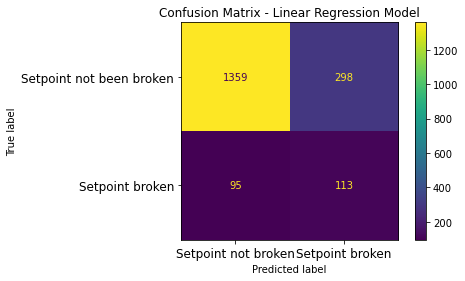

Accuracy scroe for this model =  78.92761394101878 %
F-7 Score for this model = 53.28680562105065 %


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=False, test_size=0.1)


salon_model = LogisticRegression()
salon_model.fit(X_train, y_train)
lr_predict =  salon_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predict)

plt.figure()
plot_confusion_matrix(salon_model,X_test, y_test)  
plt.title("Confusion Matrix - Linear Regression Model")
plt.xticks(range(2), ["Setpoint not broken","Setpoint broken"], fontsize=12)
plt.yticks(range(2), ["Setpoint not been broken","Setpoint broken"], fontsize=12)
plt.show()

print("Accuracy scroe for this model = ", lr_accuracy*100, "%")
print("F-7 Score for this model =",fbeta_score(y_test, lr_predict, beta=7)*100,"%")

Teraz spróbujemy ulepszyć nasz model, wykorzystamy do tego GridSearchCV, przy okazji sprawdzimy jak zachowa się gdy ustawimy `class_weight=balanced`, czyli pozwolimy mu dobrac odpowiednio wagi do poziomu zbalansowania danych kolumny `temp_breakdown`

In [12]:
from sklearn.model_selection import GridSearchCV


param_grid = {'C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],'penalty': ["l1","l2"]}
est = LogisticRegression(solver="liblinear",class_weight="balanced").fit(X_train,y_train)
sh = GridSearchCV(est, param_grid, scoring="f1")
sh.fit(X_train,y_train)
print(sh.best_params_)


{'C': 0.7, 'penalty': 'l1'}


Jak widać ostatecznie udało nam się uzyskać model którego miara F7 wynosi `70%` co jest całkiem niezłym wynikiem. Model wielokrotnie zaznaczał że punkt mógł zostać przekroczony kiedy taka sytuacja nie wystąpiła (zmniejszyła się trafność), natomiast tak jak już wspominałem w kontekscie wykrywania anomalii lepiej wykryć ich za dużo niż ominąć ich zbyt dużą ilość. Nasz model przewidział poprawnie `155` z `208` anomalii występujących w pomiarach

<Figure size 432x288 with 0 Axes>

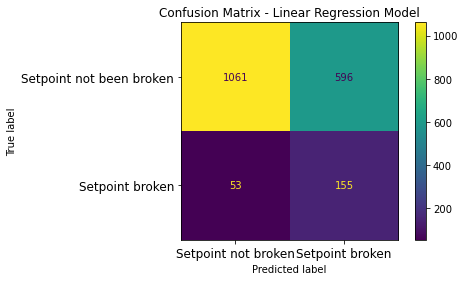

Accuracy scroe for this model =  65.20107238605898 %
F-7 Score for this model = 70.82152974504248 %


In [13]:
salon_model = LogisticRegression(solver="liblinear",class_weight="balanced", C=0.8, penalty="l1")
salon_model.fit(X_train, y_train)
lr_predict =  salon_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predict)

plt.figure()
plot_confusion_matrix(salon_model,X_test, y_test)  
plt.title("Confusion Matrix - Linear Regression Model")
plt.xticks(range(2), ["Setpoint not broken","Setpoint broken"], fontsize=12)
plt.yticks(range(2), ["Setpoint not been broken","Setpoint broken"], fontsize=12)
plt.show()

print("Accuracy scroe for this model = ", lr_accuracy*100, "%")
print("F-7 Score for this model =",fbeta_score(y_test, lr_predict, beta=7)*100,"%")

d = {'Name':["Salon"],'Accuracy': [lr_accuracy*100], 'F-7 Score': [fbeta_score(y_test, lr_predict, beta=7)*100]}
summary = pd.DataFrame(data=d)

Stwórzmy podobne modele dla innych pokoi i sprawdźmy ich skuteczność.
<h2>Gabinet</h2>

0    13458
1     3889
Name: more_than_setpoint, dtype: int64


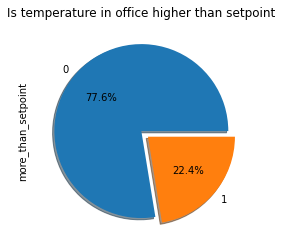

In [14]:
temp_gabinet = prepare_table("Temperatura_Gabinet.csv","actual_temp")
setpoint_gabinet = prepare_table("Setpoint_Gabinet.csv","set_temp")
grzej_gabinet = prepare_table("Grzejnik_Gabinet.csv","heater_state")
tryb_gabinet = prepare_table("Tryb_Gabinet.csv","mode")
cbo = prepare_table("Centralne_BlokadaOgrzewania.csv","cbo_state")
press = prepare_table("CisnienieAtmosferyczne.csv","pressure")
humidity = prepare_table("WilgotnoWzglendna.csv","humidity")
outside = prepare_table("TemperaturaZewnetrzna.csv","outside_temp")

gabinet_data = pd.concat([temp_gabinet,setpoint_gabinet,outside,grzej_gabinet,tryb_gabinet,cbo,press,humidity], axis=1)
gabinet_data.ffill(inplace=True)        
gabinet_data.backfill(inplace=True)
gabinet_data.reset_index(inplace=True)

first = gabinet_data.index[0]
before = np.NaN

for index, values in gabinet_data.iterrows():
    if index==first:
        before = index
    if index>5:
        delta_temp = gabinet_data.actual_temp[index] - gabinet_data.actual_temp[before]
        delta_time = gabinet_data.time[index] - gabinet_data.time[before]
        gabinet_data.at[index, 'delta_temp'] = delta_temp   #zmiana temperatury wzgledem poprzedniego pomiaru
        gabinet_data.at[index, "temp_change_factor"] = (delta_temp/(delta_time / dt.timedelta(minutes=1)))
        gabinet_data.at[index, "more_than_setpoint"] = gabinet_data.at[index,"actual_temp"]>gabinet_data.at[index,"set_temp"] and gabinet_data.at[index,"set_temp"]!=7.0 and gabinet_data.at[index,"set_temp"]>=gabinet_data.at[index-1,"set_temp"]
        if (gabinet_data.at[before+1, "more_than_setpoint"]==True or gabinet_data.at[before+2, "more_than_setpoint"]==True or gabinet_data.at[before+3, "more_than_setpoint"]==True or gabinet_data.at[before+4, "more_than_setpoint"]==True or gabinet_data.at[before+5, "more_than_setpoint"]==True or gabinet_data.at[index, "more_than_setpoint"]==True):
            gabinet_data.at[before, "temp_breakdown"] = gabinet_data.at[before,"temp_change_factor"]>0 or gabinet_data.at[before+1,"temp_change_factor"]>0 or gabinet_data.at[before+2,"temp_change_factor"]>0 or gabinet_data.at[before+3,"temp_change_factor"]>0 or gabinet_data.at[before+4,"temp_change_factor"]>0 or gabinet_data.at[before+5,"temp_change_factor"]>0 or gabinet_data.at[index,"temp_change_factor"]>0
        before = before+1

gabinet_data.fillna(inplace=True,value=0)
gabinet_data["more_than_setpoint"] = gabinet_data["more_than_setpoint"].astype(int)
gabinet_data["temp_breakdown"] = gabinet_data["temp_breakdown"].astype(int)
gabinet_data[['temp_change_factor']] = StandardScaler().fit_transform(gabinet_data[['temp_change_factor']])

print(gabinet_data['more_than_setpoint'].value_counts())
gabinet_data['more_than_setpoint'].value_counts().plot.pie(explode=[0,0.1],shadow=True,autopct='%1.1f%%',
                                              title = 'Is temperature in office higher than setpoint')

In [15]:
print(gabinet_data["temp_breakdown"].value_counts())

0    14903
1     2444
Name: temp_breakdown, dtype: int64


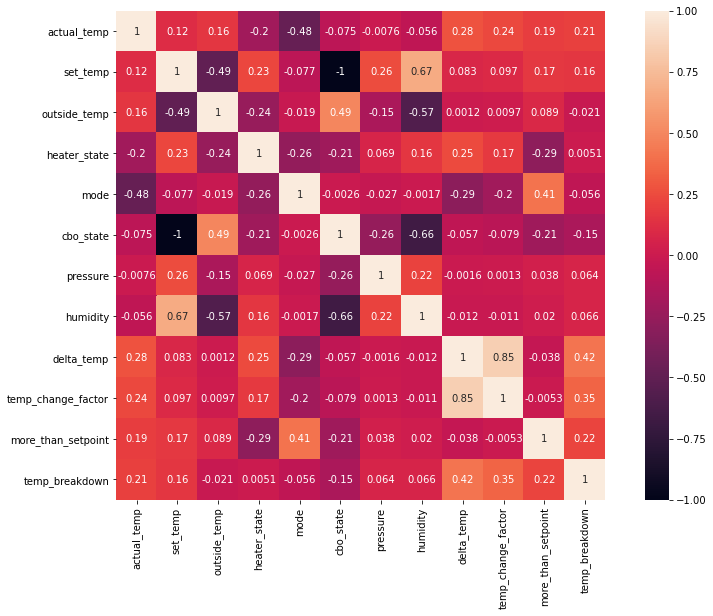

In [16]:
corr = gabinet_data.corr()
f = plt.figure(figsize = (14,9))
sns.heatmap(corr,vmax = 1,square = True,annot = True,vmin = -1)
plt.show()

<Figure size 432x288 with 0 Axes>

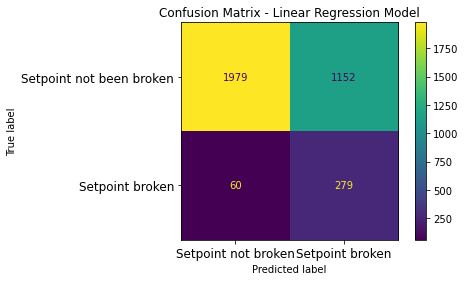

Accuracy scroe for this model =  65.07204610951008 %
F-7 Score for this model = 77.31958762886596 %


In [17]:
X = gabinet_data[['cbo_state','temp_change_factor']]
Y = gabinet_data['temp_breakdown']
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=False, test_size=0.2)


gabinet_model = LogisticRegression(solver="liblinear",class_weight="balanced", C=0.8, penalty="l1")
gabinet_model.fit(X_train, y_train)
lr_predict =  gabinet_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predict)

plt.figure()
plot_confusion_matrix(gabinet_model,X_test, y_test)  
plt.title("Confusion Matrix - Linear Regression Model")
plt.xticks(range(2), ["Setpoint not broken","Setpoint broken"], fontsize=12)
plt.yticks(range(2), ["Setpoint not been broken","Setpoint broken"], fontsize=12)
plt.show()

print("Accuracy scroe for this model = ", lr_accuracy*100, "%")
print("F-7 Score for this model =",fbeta_score(y_test, lr_predict, beta=7)*100,"%")

d = {'Name':"Gabinet",'Accuracy': lr_accuracy*100, 'F-7 Score': fbeta_score(y_test, lr_predict, beta=7)*100}
summary = summary.append(d, ignore_index=True)

<h2>Glowna Sypialnia</h2>

0    12598
1     5162
Name: more_than_setpoint, dtype: int64


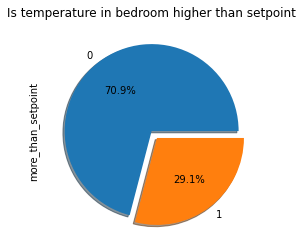

In [18]:
temp = prepare_table("Temperatura_GlownaSypialnia.csv","actual_temp")
setpoint = prepare_table("Setpoint_GlownaSypialnia.csv","set_temp")
grzej = prepare_table("Grzejnik_Glowna_Sypialnia.csv","heater_state")
tryb = prepare_table("Tryb_GlownaSypialnia.csv","mode")
cbo = prepare_table("Centralne_BlokadaOgrzewania.csv","cbo_state")
press = prepare_table("CisnienieAtmosferyczne.csv","pressure")
humidity = prepare_table("WilgotnoWzglendna.csv","humidity")
outside = prepare_table("TemperaturaZewnetrzna.csv","outside_temp")

gsyp_data = pd.concat([temp,setpoint,outside,grzej,tryb,cbo,press,humidity], axis=1)
gsyp_data.ffill(inplace=True)        
gsyp_data.backfill(inplace=True)
gsyp_data.reset_index(inplace=True)

first = gsyp_data.index[0]
before = np.NaN

for index, values in gsyp_data.iterrows():
    if index==first:
        before = index
    if index>5:
        delta_temp = gsyp_data.actual_temp[index] - gsyp_data.actual_temp[before]
        delta_time = gsyp_data.time[index] - gsyp_data.time[before]
        gsyp_data.at[index, 'delta_temp'] = delta_temp   #zmiana temperatury wzgledem poprzedniego pomiaru
        gsyp_data.at[index, "temp_change_factor"] = (delta_temp/(delta_time / dt.timedelta(minutes=1)))
        gsyp_data.at[index, "more_than_setpoint"] = gsyp_data.at[index,"actual_temp"]>gsyp_data.at[index,"set_temp"] and gsyp_data.at[index,"set_temp"]!=7.0 and gsyp_data.at[index,"set_temp"]>=gsyp_data.at[index-1,"set_temp"]
        if (gsyp_data.at[before+1, "more_than_setpoint"]==True or gsyp_data.at[before+2, "more_than_setpoint"]==True or gsyp_data.at[before+3, "more_than_setpoint"]==True or gsyp_data.at[before+4, "more_than_setpoint"]==True or gsyp_data.at[before+5, "more_than_setpoint"]==True or gsyp_data.at[index, "more_than_setpoint"]==True):
            gsyp_data.at[before, "temp_breakdown"] = gsyp_data.at[before,"temp_change_factor"]>0 or gsyp_data.at[before+1,"temp_change_factor"]>0 or gsyp_data.at[before+2,"temp_change_factor"]>0 or gsyp_data.at[before+3,"temp_change_factor"]>0 or gsyp_data.at[before+4,"temp_change_factor"]>0 or gsyp_data.at[before+5,"temp_change_factor"]>0 or gsyp_data.at[index,"temp_change_factor"]>0
        before = before+1

gsyp_data.fillna(inplace=True,value=0)
gsyp_data["more_than_setpoint"] = gsyp_data["more_than_setpoint"].astype(int)
gsyp_data["temp_breakdown"] = gsyp_data["temp_breakdown"].astype(int)
gsyp_data[['temp_change_factor']] = StandardScaler().fit_transform(gsyp_data[['temp_change_factor']])

print(gsyp_data['more_than_setpoint'].value_counts())
gsyp_data['more_than_setpoint'].value_counts().plot.pie(explode=[0,0.1],shadow=True,autopct='%1.1f%%',
                                              title = 'Is temperature in bedroom higher than setpoint')

In [19]:
print(gsyp_data["temp_breakdown"].value_counts())

0    14143
1     3617
Name: temp_breakdown, dtype: int64


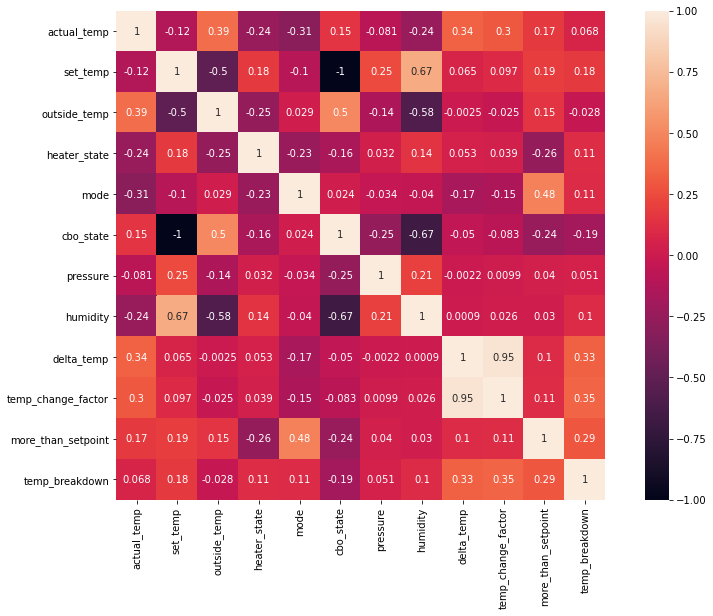

In [20]:
corr = gsyp_data.corr()
f = plt.figure(figsize = (14,9))
sns.heatmap(corr,vmax = 1,square = True,annot = True,vmin = -1)
plt.show()

<Figure size 432x288 with 0 Axes>

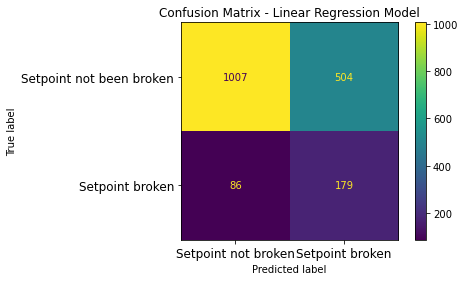

Accuracy scroe for this model =  66.77927927927928 %
F-7 Score for this model = 65.48141644717589 %


In [21]:
X = gsyp_data[["more_than_setpoint",'mode',"heater_state",'temp_change_factor']]
Y = gsyp_data['temp_breakdown']
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=False, test_size=0.1)


gysp_model = LogisticRegression(solver="liblinear",class_weight="balanced", C=0.8, penalty="l1")
gysp_model.fit(X_train, y_train)
lr_predict = gysp_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predict)

plt.figure()
plot_confusion_matrix(gysp_model,X_test, y_test)  
plt.title("Confusion Matrix - Linear Regression Model")
plt.xticks(range(2), ["Setpoint not broken","Setpoint broken"], fontsize=12)
plt.yticks(range(2), ["Setpoint not been broken","Setpoint broken"], fontsize=12)
plt.show()

print("Accuracy scroe for this model = ", lr_accuracy*100, "%")
print("F-7 Score for this model =",fbeta_score(y_test, lr_predict, beta=7)*100,"%")

d = {'Name':"Glowna Sypialnia",'Accuracy': lr_accuracy*100, 'F-7 Score': fbeta_score(y_test, lr_predict, beta=7)*100}
summary = summary.append(d, ignore_index=True)

<h2>Hol</h2>

1    9305
0    7696
Name: more_than_setpoint, dtype: int64


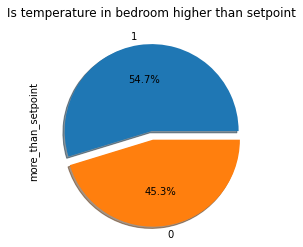

In [22]:
temp = prepare_table("Temperatura_Hol.csv","actual_temp")
setpoint = prepare_table("Setpoint_Hol.csv","set_temp")
grzej = prepare_table("Grzejnik_Parter_Podlogowka.csv","heater_state")
tryb = prepare_table("Tryb_Hol.csv","mode")
cbo = prepare_table("Centralne_BlokadaOgrzewania.csv","cbo_state")
press = prepare_table("CisnienieAtmosferyczne.csv","pressure")
humidity = prepare_table("WilgotnoWzglendna.csv","humidity")
outside = prepare_table("TemperaturaZewnetrzna.csv","outside_temp")

hol_data = pd.concat([temp,setpoint,outside,grzej,tryb,cbo,press,humidity], axis=1)
hol_data.ffill(inplace=True)        
hol_data.backfill(inplace=True)
hol_data.reset_index(inplace=True)

first = hol_data.index[0]
before = np.NaN

for index, values in hol_data.iterrows():
    if index==first:
        before = index
    if index>5:
        delta_temp = hol_data.actual_temp[index] - hol_data.actual_temp[before]
        delta_time = hol_data.time[index] - hol_data.time[before]
        hol_data.at[index, 'delta_temp'] = delta_temp   #zmiana temperatury wzgledem poprzedniego pomiaru
        hol_data.at[index, "temp_change_factor"] = (delta_temp/(delta_time / dt.timedelta(minutes=1)))
        hol_data.at[index, "more_than_setpoint"] = hol_data.at[index,"actual_temp"]>hol_data.at[index,"set_temp"] and hol_data.at[index,"set_temp"]!=7.0 and hol_data.at[index,"set_temp"]>=hol_data.at[index-1,"set_temp"]
        if (hol_data.at[before+1, "more_than_setpoint"]==True or hol_data.at[before+2, "more_than_setpoint"]==True or hol_data.at[before+3, "more_than_setpoint"]==True or hol_data.at[before+4, "more_than_setpoint"]==True or hol_data.at[before+5, "more_than_setpoint"]==True or hol_data.at[index, "more_than_setpoint"]==True):
            hol_data.at[before, "temp_breakdown"] = hol_data.at[before,"temp_change_factor"]>0 or hol_data.at[before+1,"temp_change_factor"]>0 or hol_data.at[before+2,"temp_change_factor"]>0 or hol_data.at[before+3,"temp_change_factor"]>0 or hol_data.at[before+4,"temp_change_factor"]>0 or hol_data.at[before+5,"temp_change_factor"]>0 or hol_data.at[index,"temp_change_factor"]>0
        before = before+1

hol_data.fillna(inplace=True,value=0)
hol_data["more_than_setpoint"] = hol_data["more_than_setpoint"].astype(int)
hol_data["temp_breakdown"] = hol_data["temp_breakdown"].astype(int)
hol_data[['temp_change_factor']] = StandardScaler().fit_transform(hol_data[['temp_change_factor']])

print(hol_data['more_than_setpoint'].value_counts())
hol_data['more_than_setpoint'].value_counts().plot.pie(explode=[0,0.1],shadow=True,autopct='%1.1f%%',
                                              title = 'Is temperature in bedroom higher than setpoint')

In [23]:
print(hol_data["temp_breakdown"].value_counts())

0    11241
1     5760
Name: temp_breakdown, dtype: int64


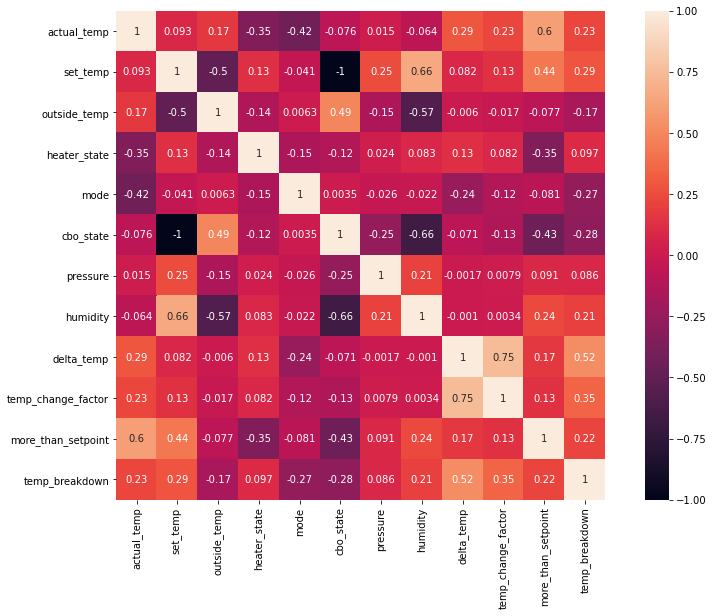

In [24]:
corr = hol_data.corr()
f = plt.figure(figsize = (14,9))
sns.heatmap(corr,vmax = 1,square = True,annot = True,vmin = -1)
plt.show()

<Figure size 432x288 with 0 Axes>

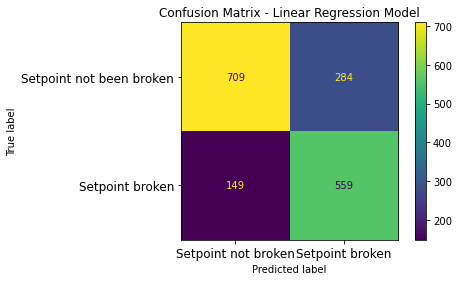

Accuracy scroe for this model =  74.54438565549677 %
F-7 Score for this model = 78.65484733361474 %


In [25]:
X = hol_data[["more_than_setpoint",'mode',"heater_state","delta_temp",'temp_change_factor']]
Y = hol_data['temp_breakdown']
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=False, test_size=0.1)


hol_model = LogisticRegression(solver="liblinear",class_weight="balanced", C=0.8, penalty="l1")
hol_model.fit(X_train, y_train)
lr_predict = hol_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predict)

plt.figure()
plot_confusion_matrix(hol_model,X_test, y_test)  
plt.title("Confusion Matrix - Linear Regression Model")
plt.xticks(range(2), ["Setpoint not broken","Setpoint broken"], fontsize=12)
plt.yticks(range(2), ["Setpoint not been broken","Setpoint broken"], fontsize=12)
plt.show()

print("Accuracy scroe for this model = ", lr_accuracy*100, "%")
print("F-7 Score for this model =",fbeta_score(y_test, lr_predict, beta=7)*100,"%")

d = {'Name':"Hol",'Accuracy': lr_accuracy*100, 'F-7 Score': fbeta_score(y_test, lr_predict, beta=7)*100}
summary = summary.append(d, ignore_index=True)

<h2>Górna Łazienka</h2>

0    11263
1     5316
Name: more_than_setpoint, dtype: int64


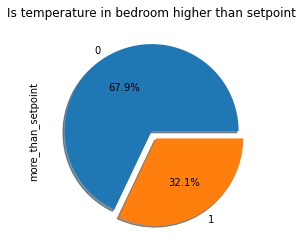

In [26]:
temp = prepare_table("Temperatura_LazienkaGorna.csv","actual_temp")
setpoint = prepare_table("Setpoint_LazienkaGorna.csv","set_temp")
grzej = prepare_table("Grzejnik_LazienkaGorna_Podlogowka.csv","heater_state")
tryb = prepare_table("Tryb_LazienkaGorna.csv","mode")
cbo = prepare_table("Centralne_BlokadaOgrzewania.csv","cbo_state")
press = prepare_table("CisnienieAtmosferyczne.csv","pressure")
humidity = prepare_table("WilgotnoWzglendna.csv","humidity")
outside = prepare_table("TemperaturaZewnetrzna.csv","outside_temp")

lg_data = pd.concat([temp,setpoint,outside,grzej,tryb,cbo,press,humidity], axis=1)
lg_data.ffill(inplace=True)        
lg_data.backfill(inplace=True)
lg_data.reset_index(inplace=True)

first = hol_data.index[0]
before = np.NaN

for index, values in lg_data.iterrows():
    if index==first:
        before = index
    if index>5:
        delta_temp = lg_data.actual_temp[index] - lg_data.actual_temp[before]
        delta_time = lg_data.time[index] - lg_data.time[before]
        lg_data.at[index, 'delta_temp'] = delta_temp   #zmiana temperatury wzgledem poprzedniego pomiaru
        lg_data.at[index, "temp_change_factor"] = (delta_temp/(delta_time / dt.timedelta(minutes=1)))
        lg_data.at[index, "more_than_setpoint"] = lg_data.at[index,"actual_temp"]>lg_data.at[index,"set_temp"] and lg_data.at[index,"set_temp"]!=7.0 and lg_data.at[index,"set_temp"]>=lg_data.at[index-1,"set_temp"]
        if (lg_data.at[before+1, "more_than_setpoint"]==True or lg_data.at[before+2, "more_than_setpoint"]==True or lg_data.at[before+3, "more_than_setpoint"]==True or lg_data.at[before+4, "more_than_setpoint"]==True or lg_data.at[before+5, "more_than_setpoint"]==True or lg_data.at[index, "more_than_setpoint"]==True):
            lg_data.at[before, "temp_breakdown"] = lg_data.at[before,"temp_change_factor"]>0 or lg_data.at[before+1,"temp_change_factor"]>0 or lg_data.at[before+2,"temp_change_factor"]>0 or lg_data.at[before+3,"temp_change_factor"]>0 or lg_data.at[before+4,"temp_change_factor"]>0 or lg_data.at[before+5,"temp_change_factor"]>0 or lg_data.at[index,"temp_change_factor"]>0
        before = before+1

lg_data.fillna(inplace=True,value=0)
lg_data["more_than_setpoint"] = lg_data["more_than_setpoint"].astype(int)
lg_data["temp_breakdown"] = lg_data["temp_breakdown"].astype(int)
lg_data[['temp_change_factor']] = StandardScaler().fit_transform(lg_data[['temp_change_factor']])

print(lg_data['more_than_setpoint'].value_counts())
lg_data['more_than_setpoint'].value_counts().plot.pie(explode=[0,0.1],shadow=True,autopct='%1.1f%%',
                                              title = 'Is temperature in bedroom higher than setpoint')

In [27]:
print(lg_data["temp_breakdown"].value_counts())

0    14065
1     2514
Name: temp_breakdown, dtype: int64


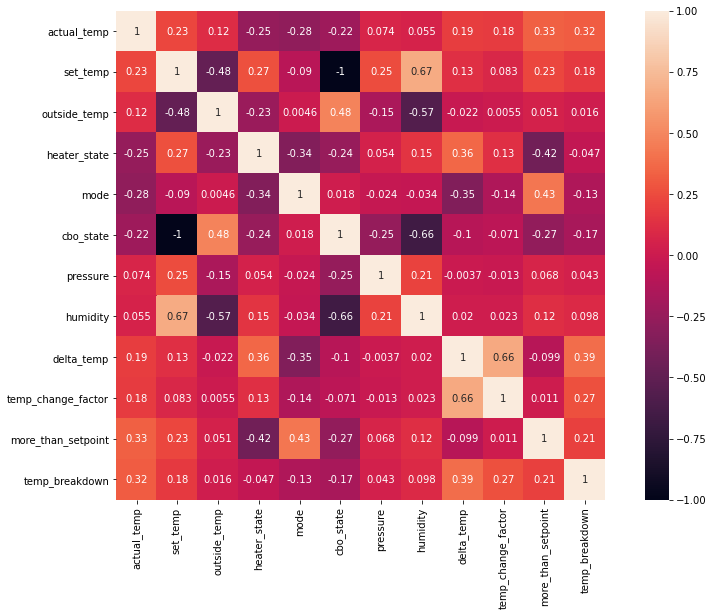

In [28]:
corr = lg_data.corr()
f = plt.figure(figsize = (14,9))
sns.heatmap(corr,vmax = 1,square = True,annot = True,vmin = -1)
plt.show()

/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


<Figure size 432x288 with 0 Axes>

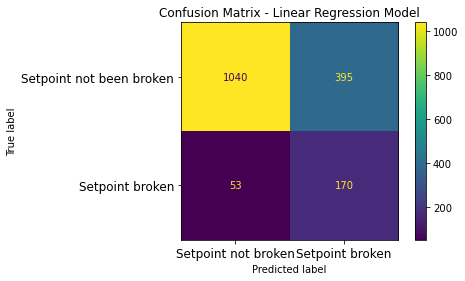

Accuracy scroe for this model =  72.9794933655006 %
F-7 Score for this model = 73.96449704142012 %


In [29]:
X = lg_data[["actual_temp","cbo_state",'temp_change_factor']]
Y = lg_data['temp_breakdown']
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=False, test_size=0.1)


lg_model = LogisticRegression(solver="liblinear",class_weight="balanced", C=0.8, penalty="l1")
lg_model.fit(X_train, y_train)
lr_predict = lg_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predict)

plt.figure()
plot_confusion_matrix(lg_model,X_test, y_test)  
plt.title("Confusion Matrix - Linear Regression Model")
plt.xticks(range(2), ["Setpoint not broken","Setpoint broken"], fontsize=12)
plt.yticks(range(2), ["Setpoint not been broken","Setpoint broken"], fontsize=12)
plt.show()

print("Accuracy scroe for this model = ", lr_accuracy*100, "%")
print("F-7 Score for this model =",fbeta_score(y_test, lr_predict, beta=7)*100,"%")

d = {'Name':"Gorna Lazienka",'Accuracy': lr_accuracy*100, 'F-7 Score': fbeta_score(y_test, lr_predict, beta=7)*100}
summary = summary.append(d, ignore_index=True)

<h2>Podsumowanie</h2>

Wszystkie modele powstały przy pomocy algorytmu regresji logistycznej. Najlepszy model który udało nam się stworzyć był dla danych zebranych w holu. Wyniki miar które sprawdzaliśmy to kolejno:
* `74,54%` Accuracy
* `78,67%` F-Beta dla Beta=7
Kluczowymi cechą która występowała w każdym modelu była kolumna `temp_change_factor` która wskazywała zmianę temperatury względem minut. Aby model mógł lepiej ją zinterpretować poddaliśmy ją standaryzacji.



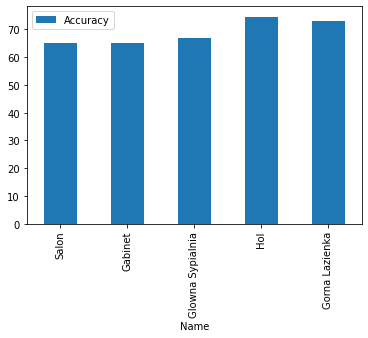

In [30]:
summary.plot(x ='Name', y='Accuracy', kind = 'bar')

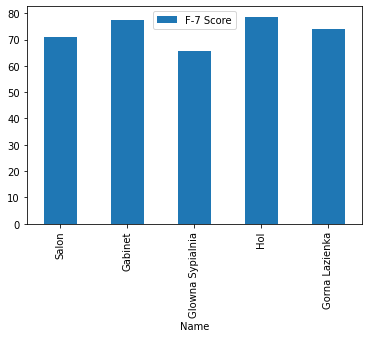

In [34]:
summary.plot(x ='Name', y='F-7 Score', kind = 'bar')

Propozycja usunięcia wykrytych błędów, w momencie gdy model wykrywa nadchodzące przebicie, system mógłby włączyć centralną blokadę ogrzewania na czas aż temperatura spadnie pół stopnia poniżej ustawionej, nie będzie to zbyt duża zmiana a powinna zapobiec nadchodzącym przebiciom.